# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

In [1]:
# Для работы с данными
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Деревое решений
from sklearn.tree import DecisionTreeClassifier
#Случайный лес 
from sklearn.ensemble import RandomForestClassifier
#Линейная регрессия
from sklearn.linear_model import LogisticRegression 

# Для деления данных
from sklearn.model_selection import train_test_split

# Оценка точности модели
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score 

#точность
from sklearn.metrics import precision_score

## Откройте и изучите файл

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


- сalls — количество звонков
- minutes — суммарная длительность звонков в минутах
- messages — количество sms-сообщений
- mb_used — израсходованный интернет-трафик в Мб
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)

In [5]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


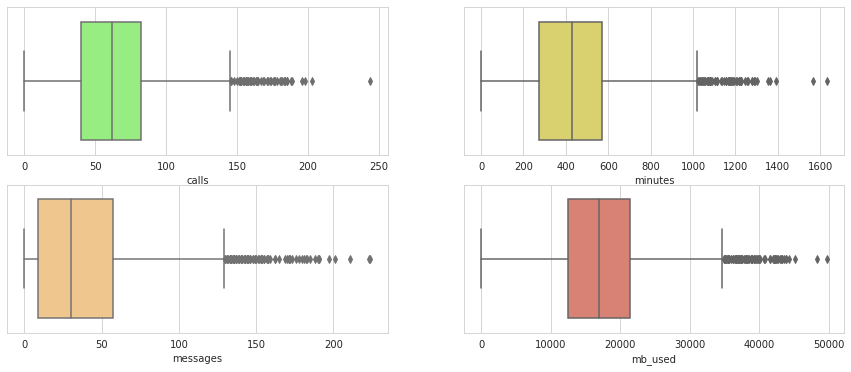

In [6]:
sns.set_style("whitegrid")
f, ax = plt.subplots(2, 2, figsize=(15, 6))

sns.boxplot(data=df, x='calls', ax=ax[0, 0], color='#8DFF70');
sns.boxplot(data=df, x='minutes', ax=ax[0, 1], color='#EBDE5E');
sns.boxplot(data=df, x='messages', ax=ax[1, 0], color='#FFC97D');
sns.boxplot(data=df, x='mb_used', ax=ax[1, 1], color='#E87566');

Виднеются некоторые выбросы.

## Разбейте данные на выборки

Конечная цель - выбор подходящего тарифа, а остальные данные будут помогать в выборе.

In [7]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

Разделим на 3 части: 60% тренировочная, 20% валидационная, 20% тестовая.

Вначале разделим на тренировочную и валидационную+тестовую.

In [8]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=.4, random_state=12345
)

А теперь поделить уже на валидационную и тестовую. Получается от оставшихся данных в каждую категорию пойдет по 50%.

In [9]:
features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid, target_valid, test_size=.5, random_state=12345
)

### Проверим баланс классов выборки

In [10]:
target_train.value_counts(normalize=1)

0    0.692427
1    0.307573
Name: is_ultra, dtype: float64

In [11]:
target_valid.value_counts(normalize=1)

0    0.684292
1    0.315708
Name: is_ultra, dtype: float64

In [12]:
target_test.value_counts(normalize=1)

0    0.706065
1    0.293935
Name: is_ultra, dtype: float64

Наблюдается заметный дисбаланс классов. Значит результаты предсказаний будут склонятся к 0.

## Исследуйте модели

### Точность моделей

Предварительно проверим модели не используя гиперпараметры.

In [13]:
# Функция для сравнения трех моделей без гиперпараметров
def all_models_accuracy(features_train, target_train, features_valid, target_valid):
    model_dtc = DecisionTreeClassifier(random_state=12345)
    trained_dtc = model_dtc.fit(features_train, target_train)
    dtc_score = trained_dtc.score(features_valid, target_valid)
    
    model_rfc = RandomForestClassifier(random_state=12345)
    trained_rfc = model_rfc.fit(features_train, target_train)
    rfc_score = trained_rfc.score(features_valid, target_valid)
    
    model_lr = LogisticRegression()
    trained_lr = model_lr.fit(features_train, target_train)
    lr_score = trained_lr.score(features_valid, target_valid)
    
    print('Точность')
    print(f'Дерево решений: {round(dtc_score * 100, 2)}%')
    print(f'Случайный лес: {round(rfc_score * 100, 2)}%')
    print(f'Логистическая регрессия: {round(lr_score * 100, 2)}%')

In [14]:
all_models_accuracy(features_train, target_train, features_valid, target_valid)

Точность
Дерево решений: 73.09%
Случайный лес: 78.54%
Логистическая регрессия: 68.43%


Победителем вышел Случайный Лес.

В целом Случайный Лес уже 78% угадывает правильно. Переберем гиперпараметры, чтобы улучшить модель. 

### Улучшение модели

Переберем гиперпараметры для победившей модели, чтобы оптимизировать ее.

In [15]:
# Функция, которая будет обучать модель и выводить точность и mse
def accuracy_best_model(features_train, target_train, features_valid, target_valid, est, max_depth):
    # Обучим модель
    model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=max_depth)
    trained_model = model.fit(features_train, target_train)
    
    # Посчитаем ее точность и mse
    rfc_score = trained_model.score(features_valid, target_valid)
    rfc_precision_score = precision_score(target_valid, trained_model.predict(features_valid))
    
    return rfc_score, rfc_precision_score

In [16]:
best_model = None
best_score = 0
best_precision_score = 0

# Глубина деревьев
for max_depth in range(1, 100):          
        score, rfc_precision_score = accuracy_best_model(
            features_train, target_train, features_valid, target_valid, 10, max_depth
        )
        
        # Запишем характеристики лучшей модели
        if best_score < score:
            best_score = score
            best_depth = max_depth
            best_precision_score = rfc_precision_score

print(
    f'У лучшей модели:\
    \n\t- {best_depth} - глубина деревьев\
    \n\t- {round(best_score*100, 2)}% - аккуратность\
    \n\t- {round(best_precision_score*100, 2)}% - точность'
)

У лучшей модели:    
	- 9 - глубина деревьев    
	- 81.34% - аккуратность    
	- 80.29% - точность


## Проверьте модель на тестовой выборке

In [17]:
final_model = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=best_depth)
final_model.fit(features_train, target_train)

final_predict = final_model.predict(features_test)

final_model_accuracy = accuracy_score(target_test, final_predict)
final_precision_score = precision_score(target_test, final_predict)

print(
    f'Аккуратность: {final_model_accuracy * 100} %\
    \nТочность: {final_precision_score * 100} %'
)

Аккуратность: 79.47122861586314 %    
Точность: 72.8 %


Точность получется ниже.

## (бонус) Проверьте модели на адекватность

Чтобы проверить сравнить модель со случайной, посмотрим на общие данные еще раз, а именно на цель.

In [18]:
target.value_counts(normalize=1)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

В выборках будет примерно такое же распределение данных. Тогда посчитаем каков шанс угадать значения. Так как 0 в данных 69%, значит процент угадать его именно такой. Для 1 - 31%.

In [19]:
(target.value_counts()[0] * .69 + target.value_counts()[1] * .31) / target.shape[0]

0.5735407591785937

Более того, самая репрезентованный класс здесь встречается в 69%, лучшая же модель бьет и этот показатель

Точность финальной модели выше случайной, значит модель относительно адекватна.

## Вывод

1. В данных наблюдается дисбаланс (0.7 / 0.3).
2. Лучший результат по предсказанию без изменения гиперпараметров среди моделей был у *Random Forest Classifier*, потому эта модель и была выбрана.
3. Для улучшения модели перебирался гиперпараметр max_depth. После чего удалось добиться точности 81.34%.
4. После проверки на тестовой выборке модель показала точность ниже: 79.47%.
5. Чтобы проверить модель на адекватность она мы ее сравнили с случайной. Так у случайной модели точность была бы примерно 57%, когда наша модель на тестовой выборке показала результат в 79.47%, чем прошла проверку.